In [1]:
import pandas as pd
import numpy as np
import pickle

In [3]:
file_names = {
    "train": "data/nlfl_train_sample_v2.xlsx",
    "test": "data/nlfl_test_sample_v2.xlsx",
    "val": "data/nlfl_val_sample_v2.xlsx",
}

In [4]:
A_train = pd.read_excel(file_names["train"], index_col="id").sample(frac = 1, random_state=2022).reset_index()
A_val = pd.read_excel(file_names["val"])
A_test = pd.read_excel(file_names["test"])

<AxesSubplot: >

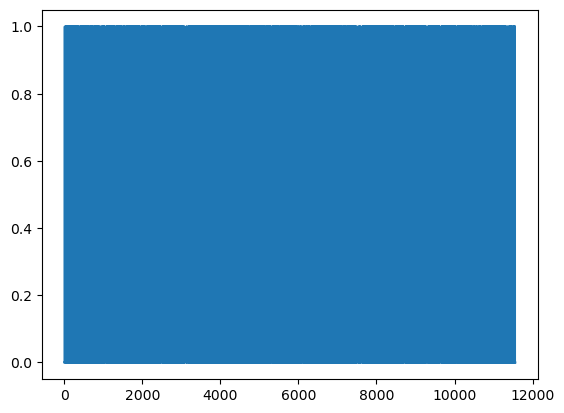

In [5]:
A_train["label"].plot()

In [8]:
rel_cols = [c for c in A_train.columns if "chatgpt_label" != c and "chatgpt_" in c]
rel_cols

['chatgpt_v1 (N)',
 'chatgpt_v1 (Y)',
 'chatgpt_v2 (N)',
 'chatgpt_v2 (Y)',
 'chatgpt_v3 (N)',
 'chatgpt_v3 (Y)',
 'chatgpt_v4 (N)',
 'chatgpt_v4 (Y)',
 'chatgpt_v5 (N)',
 'chatgpt_v5 (Y)',
 'chatgpt_v6 (N)',
 'chatgpt_v6 (Y)',
 'chatgpt_v7 (N)',
 'chatgpt_v7 (Y)',
 'chatgpt_v8 (N)',
 'chatgpt_v8 (Y)',
 'chatgpt_v9 (N)',
 'chatgpt_v9 (Y)',
 'chatgpt_v10 (N)',
 'chatgpt_v10 (Y)',
 'chatgpt_v5_1 (N)',
 'chatgpt_v5_1 (Y)',
 'chatgpt_v5_2 (N)',
 'chatgpt_v5_2 (Y)',
 'chatgpt_v5_3 (N)',
 'chatgpt_v5_3 (Y)',
 'chatgpt_v5_4 (N)',
 'chatgpt_v5_4 (Y)',
 'chatgpt_v5_5 (N)',
 'chatgpt_v5_5 (Y)',
 'chatgpt_v6_1 (N)',
 'chatgpt_v6_1 (Y)',
 'chatgpt_v6_2 (N)',
 'chatgpt_v6_2 (Y)',
 'chatgpt_v6_3 (N)',
 'chatgpt_v6_3 (Y)',
 'chatgpt_v6_4 (N)',
 'chatgpt_v6_4 (Y)',
 'chatgpt_Q3_1 (N)',
 'chatgpt_Q3_1 (Y)',
 'chatgpt_Q3_2 (N)',
 'chatgpt_Q3_2 (Y)',
 'chatgpt_Q3_3 (N)',
 'chatgpt_Q3_3 (Y)',
 'chatgpt_Q3_4 (N)',
 'chatgpt_Q3_4 (Y)',
 'chatgpt_Q3_5 (N)',
 'chatgpt_Q3_5 (Y)',
 'chatgpt_Q3_6 (N)',
 'chatgpt

In [35]:
%%time
new_A_test = A_test.copy().drop(columns=rel_cols)
new_A_train = A_train.copy().drop(columns=rel_cols)
new_A_val = A_val.copy().drop(columns=rel_cols)

bigcut = list(set([c.split()[0] for c in rel_cols]))

for bc in bigcut:
    new_A_train[bc]  = A_train[f"{bc} (Y)"] / A_train[[f'{bc} (N)',f'{bc} (Y)']].sum(axis=1)
    new_A_test[bc]  = A_test[f"{bc} (Y)"] / A_test[[f'{bc} (N)',f'{bc} (Y)']].sum(axis=1)
    new_A_val[bc]  = A_val[f"{bc} (Y)"] / A_val[[f'{bc} (N)',f'{bc} (Y)']].sum(axis=1)

CPU times: user 146 ms, sys: 0 ns, total: 146 ms
Wall time: 145 ms


In [27]:
%%capture
!pip install transformers
!pip install datasets
!pip install torch

In [28]:
from transformers import BertTokenizer, BertModel
import torch

In [29]:
model_name = "dccuchile/bert-base-spanish-wwm-cased"
beto_model = BertModel.from_pretrained(model_name)
beto_tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False)
e = beto_model.eval()

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
beto_tokenizer.all_special_tokens, beto_tokenizer.all_special_ids

(['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'], [3, 5, 1, 4, 0])

In [31]:
from torch.utils.data import Dataset
class DatasetTaskC1(Dataset):
    def __init__(self, df, maxlen):
        self.df = df
        self.tokenizer = beto_tokenizer
        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sentence1 = str(self.df.loc[index, 'Q'])
        sentence2 = str(self.df.loc[index, 'A'])
        
        sentence1 = " ".join(str(sentence1).replace("\n", " ").split())
        sentence2 = " ".join(str(sentence2).replace("\n", " ").split())

        label = self.df.loc[index, 'label']
        
        tokens1 = self.tokenizer.tokenize(sentence1) if len(sentence1)>0 else ["[UNK]"]
        tokens2 = self.tokenizer.tokenize(sentence2) if len(sentence2)>0 else ["[UNK]"]

        if len(tokens1) < self.maxlen:
            tokens1 = tokens1 + ['[PAD]' for _ in range(self.maxlen - len(tokens1))]
        else:
            tokens1 = tokens1[:self.maxlen]

        if len(tokens2) < self.maxlen:
            tokens2 = tokens2 + ['[PAD]' for _ in range(self.maxlen - len(tokens2))]
        else:
            tokens2 = tokens2[:self.maxlen]
          
        tokens = ["[CLS]"]+tokens1+["[SEP]"]+tokens2+["[SEP]"]
        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        tokens_ids_tensor = torch.tensor(tokens_ids)
        attn_mask = (tokens_ids_tensor != 1).long() # [PAD] => 1

        mf_tensor = torch.tensor(self.df.loc[index, :][bigcut])

        return mf_tensor, tokens_ids_tensor, attn_mask, label

In [36]:
from torch.utils.data import DataLoader

train_set = DatasetTaskC1(df = new_A_train, maxlen = 60)
val_set = DatasetTaskC1(df = new_A_val, maxlen = 60)

train_loader = DataLoader(train_set, batch_size = 32, num_workers = 2, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 32, num_workers = 2, shuffle=False)

In [64]:
import torch.nn as nn
class C1Classifier(nn.Module):
    def __init__(self):
        super(C1Classifier, self).__init__()
        torch.manual_seed(2022)
        
        self.bert_layer = BertModel.from_pretrained(model_name).cuda()
        self.cls_layer = nn.Linear(66+768, 2).cuda()

    def forward(self, mfs, seq, attn_masks):

        cont_reps = self.bert_layer(seq, attention_mask=attn_masks)
        
        cls_rep = cont_reps.last_hidden_state[:, 0]
        mfs = mfs.to(cls_rep.dtype)
        cls_rep = torch.cat((mfs,cls_rep), 1)

        logits = self.cls_layer(cls_rep)

        return logits

In [65]:
import torch.optim as optim

net = C1Classifier()

weights = torch.tensor([1., 6.5])
criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean').cuda()

opti = optim.Adam(net.parameters(), lr = 2e-5)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
def get_accuracy_from_logits(logits, labels):
    probs = torch.sigmoid(logits)
    soft_probs = probs.argmax(1)
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc
    
def evaluate(net, criterion, dataloader):
    net.eval()
    mean_acc, mean_loss = 0, 0
    count = 0
    with torch.no_grad():
        for mfs, seq, attn_masks, labels in dataloader:
            mfs, seq, attn_masks, labels = mfs.cuda(), seq.cuda(), attn_masks.cuda(), labels.cuda()
            logits = net(mfs, seq, attn_masks)
            mean_loss += criterion(logits, labels).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def evaluate_precision_recall_fscore_support(net, dataloader):
    net.eval()
    preds = []
    tests = []
    with torch.no_grad():
        for mfs, seq, attn_masks, labels in dataloader:
            mfs, seq, attn_masks, labels = mfs.cuda(), seq.cuda(), attn_masks.cuda(), labels.cuda()
            logits = net(mfs, seq, attn_masks)
            probs = torch.sigmoid(logits)
            soft_probs = probs.argmax(1)
            preds += soft_probs.squeeze().tolist()
            tests += labels.tolist()
    return tests, preds

In [41]:
def train(net, criterion, opti, train_loader, val_loader, epochs):
    for ep in range(epochs):
        for it, (mfs, seq, attn_masks, labels) in enumerate(train_loader):
            opti.zero_grad()  

            mfs, seq, attn_masks, labels = mfs.cuda(), seq.cuda(), attn_masks.cuda(), labels.cuda()

            logits = net(mfs, seq, attn_masks)

            loss = criterion(logits, labels)

            loss.backward()

            opti.step()

            if (it + 1) % 100 == 0:
                acc = get_accuracy_from_logits(logits, labels)
                # tests, preds = evaluate_precision_recall_fscore_support(net, train_loader)
                # print(classification_report(tests, preds))
                print("Iteration {} of epoch {} complete. Loss : {} Train Accuracy : {}".format(it+1, ep+1, loss.item(), acc))
        val_acc, val_loss = evaluate(net, criterion, val_loader)
        tests, preds = evaluate_precision_recall_fscore_support(net, val_loader)
        print(classification_report(tests, preds))
        print("Epoch {} complete! Validation Accuracy : {}, Validation Loss : {}".format(ep+1, val_acc, val_loss))

In [66]:
epochs = 7
train(net, criterion, opti, train_loader, val_loader, epochs)

Iteration 100 of epoch 1 complete. Loss : 0.3337494432926178 Train Accuracy : 0.9375
Iteration 200 of epoch 1 complete. Loss : 0.24811017513275146 Train Accuracy : 0.90625
Iteration 300 of epoch 1 complete. Loss : 0.5886850953102112 Train Accuracy : 0.9375
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2510
           1       0.81      0.80      0.80       388

    accuracy                           0.95      2898
   macro avg       0.89      0.88      0.89      2898
weighted avg       0.95      0.95      0.95      2898

Epoch 1 complete! Validation Accuracy : 0.9478785395622253, Validation Loss : 0.2640212265426641
Iteration 100 of epoch 2 complete. Loss : 0.031450241804122925 Train Accuracy : 0.96875
Iteration 200 of epoch 2 complete. Loss : 0.03476683795452118 Train Accuracy : 1.0
Iteration 300 of epoch 2 complete. Loss : 0.04133869707584381 Train Accuracy : 1.0
              precision    recall  f1-score   support

          

In [43]:
from huggingface_hub import notebook_login

In [1]:
notebook_login()

NameError: name 'notebook_login' is not defined

In [45]:
!git config --global credential.helper store

In [2]:
repo_name = "beto_nllf_ft_task_C1"
net.bert_layer.push_to_hub(repo_name)

NameError: name 'net' is not defined

In [3]:
val_set.tokenizer.push_to_hub(repo_name)

NameError: name 'val_set' is not defined

In [48]:
torch.save(net.cls_layer, "cls_layer.torch")

In [49]:
from huggingface_hub import hf_hub_url, cached_download

In [4]:
repo_name = "beto_nllf_ft_task_C1"
config_file_url = hf_hub_url("X/"+repo_name, filename="cls_layer.torch")
value = cached_download(config_file_url)
cls_layer = torch.load(value)

NameError: name 'hf_hub_url' is not defined

In [51]:
beto_model = BertModel.from_pretrained("X/"+repo_name).cuda()
beto_tokenizer = BertTokenizer.from_pretrained("X/"+repo_name, do_lower_case=False)
e = beto_model.eval()

In [52]:
def preproccesing(Q, A, maxlen=60):
        sentence1 = str(Q)
        sentence2 = str(A)
        
        sentence1 = " ".join(str(sentence1).replace("\n", " ").split())
        sentence2 = " ".join(str(sentence2).replace("\n", " ").split())
        
        tokens1 = beto_tokenizer.tokenize(sentence1) if len(sentence1)>0 else ["[UNK]"]
        tokens2 = beto_tokenizer.tokenize(sentence2) if len(sentence2)>0 else ["[UNK]"]

        if len(tokens1) < maxlen:
            tokens1 = tokens1 + ['[PAD]' for _ in range(maxlen - len(tokens1))]
        else:
            tokens1 = tokens1[:maxlen]

        if len(tokens2) < maxlen:
            tokens2 = tokens2 + ['[PAD]' for _ in range(maxlen - len(tokens2))]
        else:
            tokens2 = tokens2[:maxlen]
          
        tokens = ["[CLS]"]+tokens1+["[SEP]"]+tokens2+["[SEP]"]
        # tokens = [x for x in tokens if x!="[PAD]"]
        tokens_ids = beto_tokenizer.convert_tokens_to_ids(tokens)
        tokens_ids_tensor = torch.tensor(tokens_ids)
        attn_mask = (tokens_ids_tensor != 1).long() # [PAD] => 1

        return tokens_ids_tensor.cuda(), attn_mask.cuda()

In [53]:
def C1Classifier(mfs, Q, A):
    tokens_ids_tensor, attn_mask = preproccesing(Q, A)
    cont_reps = beto_model(tokens_ids_tensor.unsqueeze(0), attention_mask = attn_mask.unsqueeze(0))
    cls_rep = cont_reps.last_hidden_state[:, 0]
    mfs = torch.tensor(mfs).cuda()
    mfs = mfs.to(cls_rep.dtype).unsqueeze(0)
    cls_rep = torch.cat((mfs,cls_rep), 1)
    logits = cls_layer(cls_rep)
    probs = torch.sigmoid(logits)
    return probs.detach().cpu().numpy()[0]

In [54]:
i = 0
mfs = new_A_train.iloc[i][bigcut]
Q = A_train.iloc[i]["Q"], 
A = A_train.iloc[i]["A"]
print(Q, A)
C1Classifier(mfs, Q, A)

('Luis compró 10 caramelos, de los cuales 4 tenían menta, los demás no. ¿Cuántos caramelos no tenían menta? Representa esta ecuación.',) tiene 30 en total


array([0.92760646, 0.10513163], dtype=float32)

In [55]:
from sklearn.metrics import classification_report

In [56]:
%%time
y_pred = [ int(
    C1Classifier(
        mfs=new_A_train.iloc[i][bigcut], 
        Q=A_train.iloc[i]["Q"], 
        A=A_train.iloc[i]["A"]
        )[0]<0.5) 
    for i in range(A_train.shape[0])
]
report = classification_report(A_train["label"], y_pred, output_dict=True)
train_report = pd.DataFrame(report)
train_report

CPU times: user 1min 55s, sys: 38.5 ms, total: 1min 55s
Wall time: 1min 55s


,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.882521,0.982265,0.941261,0.984348
recall,0.979539,1.000000,0.982265,0.989769,0.982265
f1-score,0.989664,0.937595,0.982265,0.963629,0.982727
support,10019.000000,1540.000000,0.982265,11559.000000,11559.000000


In [57]:
pickle.dump(y_pred, open("data/y_pred_train_beto_nllf_ft_task_C1.pickle", "wb"))

In [58]:
%%time
y_pred = [ int(
    C1Classifier(
        new_A_val.iloc[i][bigcut], 
        A_val.iloc[i]["Q"], 
        A_val.iloc[i]["A"]
        )[0]<0.5) 
    for i in range(A_val.shape[0])]
report = classification_report(A_val["label"], y_pred, output_dict=True)
val_report = pd.DataFrame(report)
val_report

CPU times: user 28.7 s, sys: 4.36 ms, total: 28.7 s
Wall time: 28.7 s


,0,1,accuracy,macro avg,weighted avg
precision,0.981743,0.704918,0.935128,0.843330,0.944680
recall,0.942629,0.886598,0.935128,0.914614,0.935128
f1-score,0.961789,0.785388,0.935128,0.873588,0.938171
support,2510.000000,388.000000,0.935128,2898.000000,2898.000000


In [59]:
pickle.dump(y_pred, open("data/y_pred_val_beto_nllf_ft_task_C1.pickle", "wb"))

In [60]:
%%time
y_pred = [ int(
    C1Classifier(
        new_A_test.iloc[i][bigcut], 
        A_test.iloc[i]["Q"], 
        A_test.iloc[i]["A"]
        )[0]<0.5) 
    for i in range(A_test.shape[0])]
report = classification_report(A_test["label"], y_pred, output_dict=True)
test_report = pd.DataFrame(report)
test_report

CPU times: user 6.57 s, sys: 3.96 ms, total: 6.58 s
Wall time: 6.58 s


,0,1,accuracy,macro avg,weighted avg
precision,0.966292,0.521552,0.813885,0.743922,0.876950
recall,0.794824,0.889706,0.813885,0.842265,0.813885
f1-score,0.872211,0.657609,0.813885,0.764910,0.829100
support,541.000000,136.000000,0.813885,677.000000,677.000000


In [61]:
pickle.dump(y_pred, open("data/y_pred_test_beto_nllf_ft_task_C1.pickle", "wb"))

In [2]:
import pandas as pd 
import pickle
from sklearn.metrics import classification_report
import numpy as np

file_names = {
    "train": "data/train_task_C1.xlsx",
    "test": "data/test_task_C1.xlsx",
    "val": "data/val_task_C1.xlsx",
    "mf_train": "data/mf_features_train_task_C1.xlsx",
    "mf_test": "data/mf_features_test_task_C1.xlsx",
    "mf_val": "data/mf_features_val_task_C1.xlsx",
}
A_test = pd.read_excel(file_names["test"])
test_label_Q = pd.read_excel("data/gpt_label_v7_comp.xlsx")
A_test["label_Q"] = A_test.apply(lambda x: test_label_Q[test_label_Q["id"] == x["id"]].iloc[0]["tipo_preg"], axis=1)
y_pred = pickle.load(open("data/y_pred_test_beto_nllf_ft_task_C1.pickle", "rb"))
sub_index_test = A_test["label_Q"] == 3
print(classification_report(A_test.loc[A_test[sub_index_test].index]["label"], np.array(y_pred)[sub_index_test.values], digits=4))

              precision    recall  f1-score   support

           0     0.9811    0.9924    0.9867       262
           1     0.9474    0.8780    0.9114        41

    accuracy                         0.9769       303
   macro avg     0.9643    0.9352    0.9491       303
weighted avg     0.9766    0.9769    0.9765       303

